# Setting Up Environment
```bash
$ python -m venv tempo
$ source tempo/bin/activate # for linux
$ ./tempo/Scripts/activate # for windows
$ python.exe -m pip install --upgrade pip # upgrade pip
$ pip install -r requirements.txt
```

In [31]:
# Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import soundfile as sf
import librosa
import scipy

# Import Library
from lib.getNovel import getNovel
from lib.getPLP import getPLP
from lib.getTempogram import getTempogram
import lib.helpers as helpers

def __get_tempo_global(tempogram, F_coef_BPM):
    # Average the tempogram along the tempo axis
    tempo = np.average(tempogram, axis=1)
    # Taking the tempo with the highest value
    tempo = F_coef_BPM.item(np.argmax(tempo))
    return tempo

def final_results(track_name, start=None, end=None, window_length=2048, hop_size=512, Theta=np.arange(20,191, 1)):
    # Load Track
    track, sr = sf.read(track_name)
    if track.shape[1] > 1:
        track = track[:, 0]
    # Get Start and End
    if start is None:
        start = 0
    if end is None:
        end = len(track)
    track = track[start*sr:end*sr]
    # Get Novelty Function
    novelty, fs_feature = getNovel(track, sr,  window_length, hop_size, M = 10, norm=True)
    # Plot Novelty Function with Peaks
    helpers.plot_curve(novelty, fs_feature, title='Novelty Function', get_peaks=False)
    # Get Antocorrelation Tempogram
    tempogram_A, T_coef, F_coef, X_cut, F_coef_lag_cut = getTempogram(novelty, fs_feature, window_length, hop_size, Theta, mode='autocorr', norm=True)
    # Global Tempo Estimation using AutoCorrelation Tempogram
    tempo_A = __get_tempo_global(tempogram_A, F_coef)
    print('Estimated Tempo (AutoCorr):', tempo_A, 'bpm')
    # Plot Acorrelation Tempogram
    helpers.plot_tempogram(tempogram_A, T_coef, F_coef, title='Autocorrelation Tempogram', fit_pulse=True)
    # Get PLP
    L = len(novelty)
    plp_A = getPLP(tempogram_A, fs_feature, L, window_length, hop_size, Theta)
    # Plot PLP
    helpers.plot_curve(plp_A, sr, title='PLP (AutoCorr)', get_peaks=True)
    # Get Fourier Tempogram
    tempogram_F, T_coef, F_coef = getTempogram(novelty, fs_feature, window_length, hop_size, Theta, mode='fourier')
    # Plot Tempogram
    helpers.plot_tempogram(tempogram_F, T_coef, F_coef, title='Tempogram', fit_pulse=True)
    # Get PLP
    plp_F = getPLP(tempogram_F, fs_feature, L, window_length, hop_size, Theta)
    # Plot PLP
    helpers.plot_curve(plp_F, sr, title='PLP (Fourier)', get_peaks=True)
    # Extract the beats, concatenate with the audio and play
    beats_sec = np.arange(0, len(plp_A)) / fs_feature
    peaks = scipy.signal.find_peaks(plp_A, prominence=0.02)[0]
    peaks_s = beats_sec[peaks]
    beats = librosa.clicks(times=peaks_s, sr=sr, length=len(track))
    # ipd.display(ipd.Audio(track + beats, rate=sr))
    write_title=track_name.split('.')[0] + '_beats_auto.wav'
    sf.write(write_title, track + beats, sr)
    beat_ACF = peaks
    beat_ACF_s = peaks_s

    # Extract the beats, concatenate with the audio and play
    beats_sec = np.arange(0, len(plp_F)) / fs_feature
    peaks = scipy.signal.find_peaks(plp_F, prominence=0.02)[0]
    peaks_s = beats_sec[peaks]
    beats = librosa.clicks(times=peaks_s, sr=sr, length=len(track))
    # ipd.display(ipd.Audio(track + beats, rate=sr))
    write_title=track_name.split('.')[0] + '_beats_fourier.wav'
    sf.write(write_title, track + beats, sr)
    beat_Fourier = peaks
    beat_Fourier_s = peaks_s
    return beat_ACF, beat_ACF_s, beat_Fourier, beat_Fourier_s

# Field Testing
First we perform Autocorrelation variation then Fourier Tempogram Variant. In general the Autocorrelation varition produce a smoother tempo cruve than the Fourier Tempogram. Although when create a click based on the results, the smoother tempo curve have a hard time detecting slight change in the beat, but more accurate in detecting large tempo change. The Fourier Tempogram is more sensitive to slight tempo change, but have a hard time detecting large tempo change. Both method suffers from a large decrease in tempo, causing them to click too fast (Track 3).

## Track 1

Estimated Tempo (AutoCorr): 140 bpm


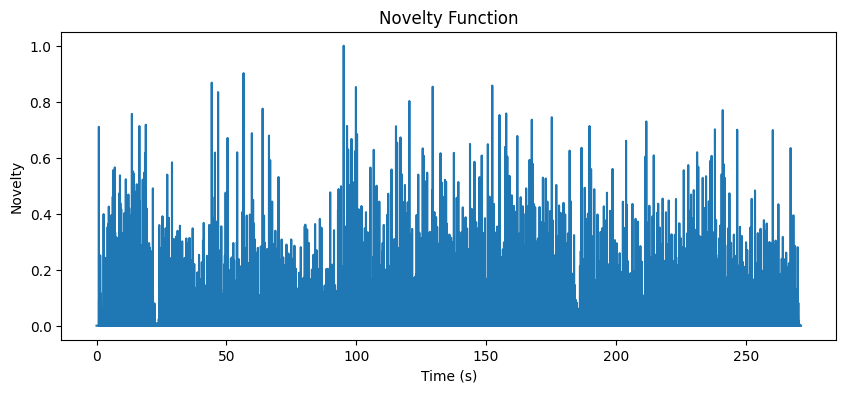

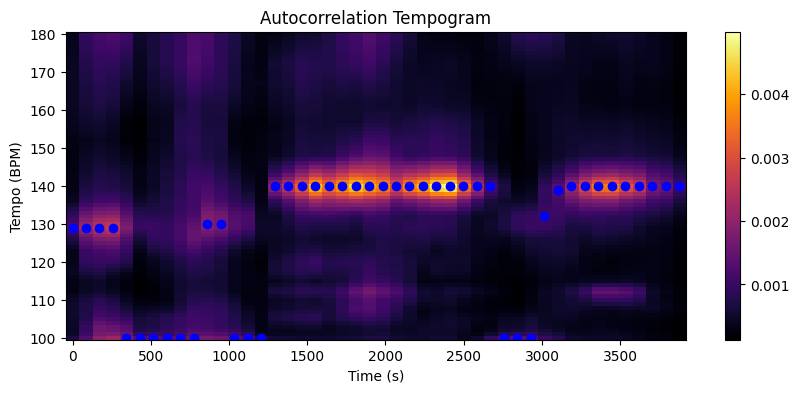

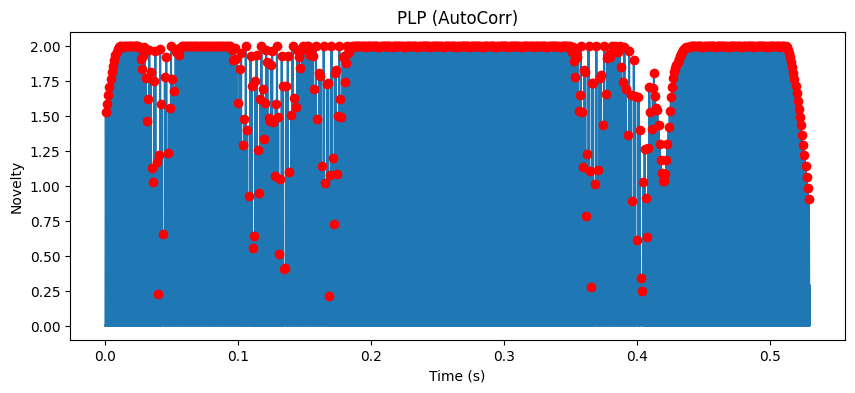

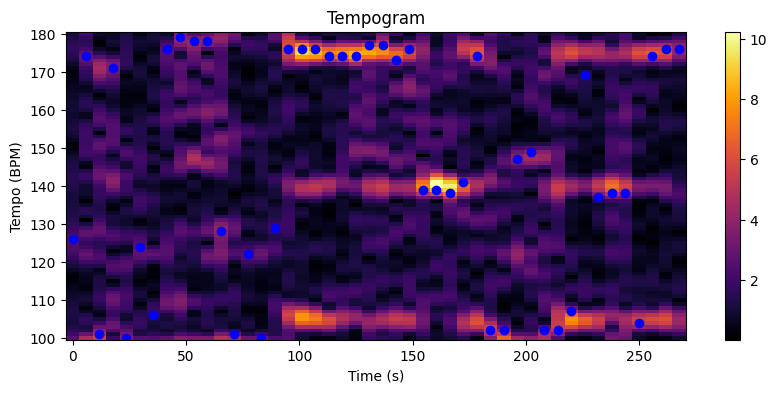

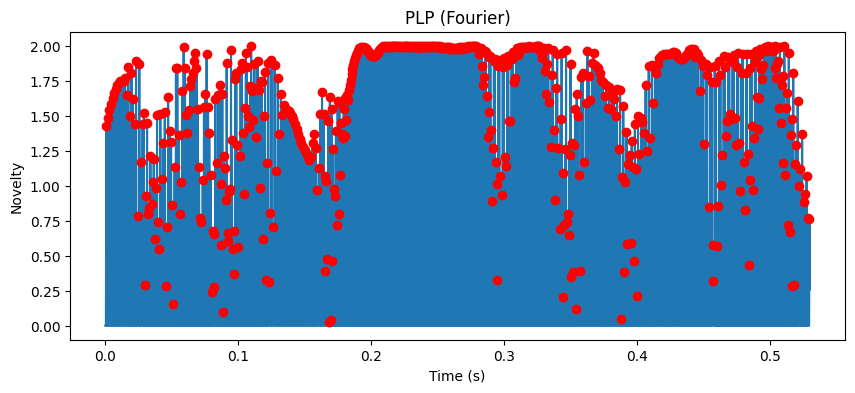

In [32]:
Theta = np.arange(100,181, 1)
beat_ACF, beat_ACF_s, beat_Fourier, beat_Fourier_s = final_results('res/Track 1.mp3', Theta = Theta)

## Track 2

Estimated Tempo (AutoCorr): 100 bpm


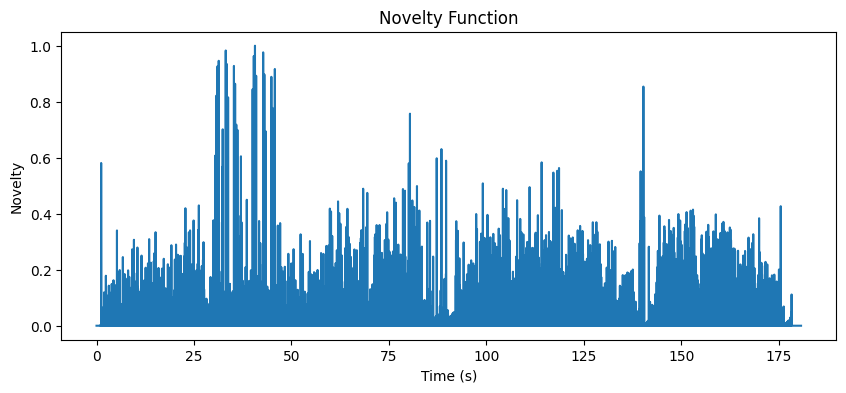

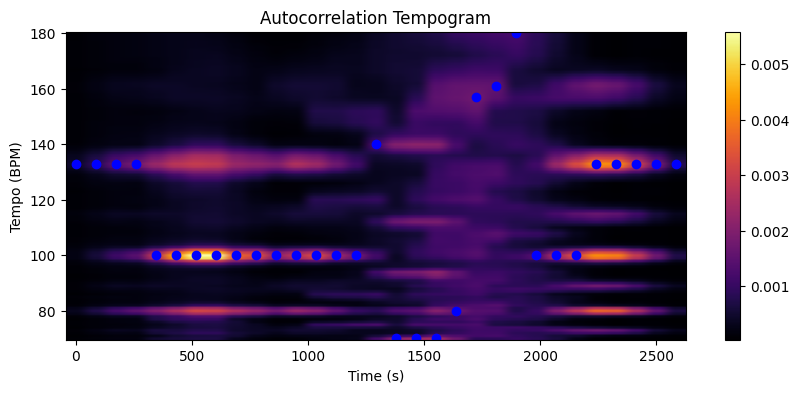

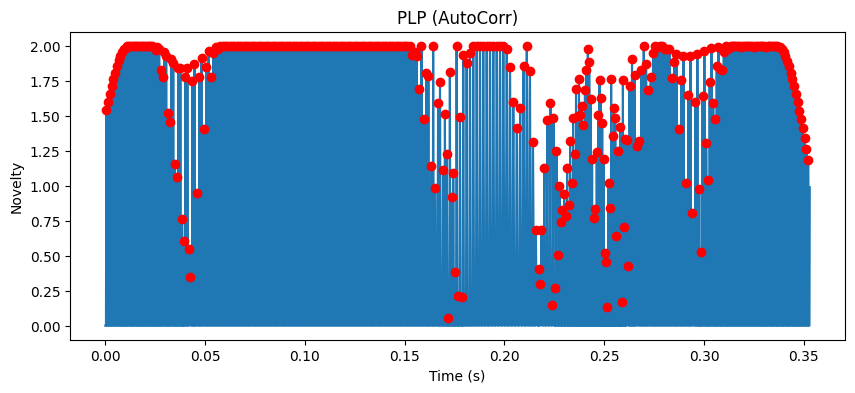

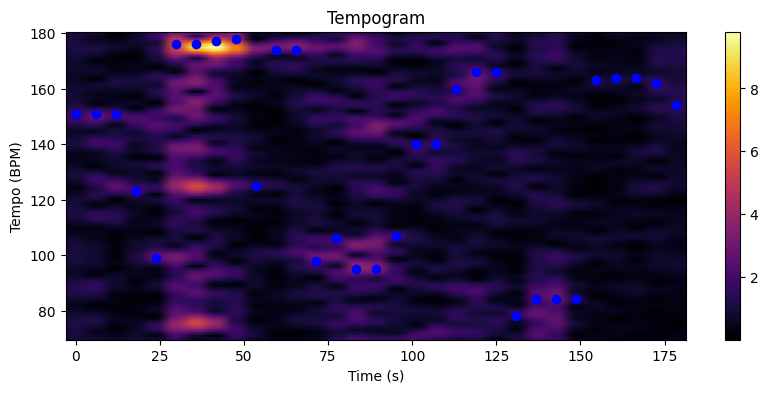

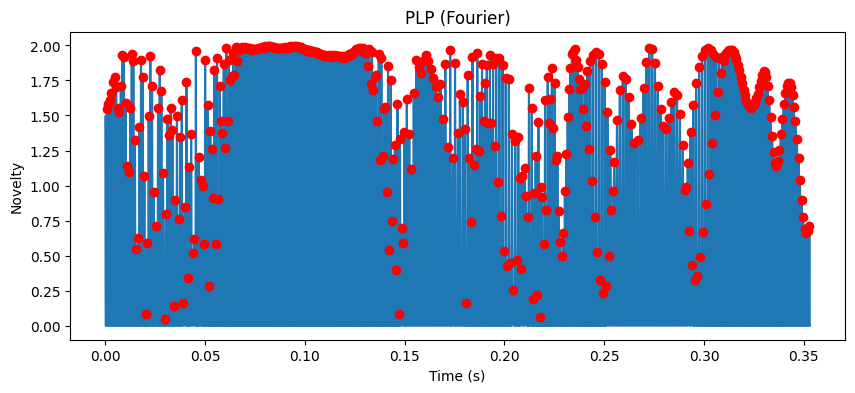

In [33]:
Theta = np.arange(70,181, 1)
beat_ACF, beat_ACF_s, beat_Fourier, beat_Fourier_s = final_results('res/Track 2.mp3',Theta=Theta)

## Track 3
Autocorrelation: there's a slight off of the beat around the 10 second mark, last until second 50. It tracked well during a chorus part then the part after.

Fourier: It tracked well during the first section. It suffers a lot during the slowed down section, but regained accuracy during the increase.

Estimated Tempo (AutoCorr): 161 bpm


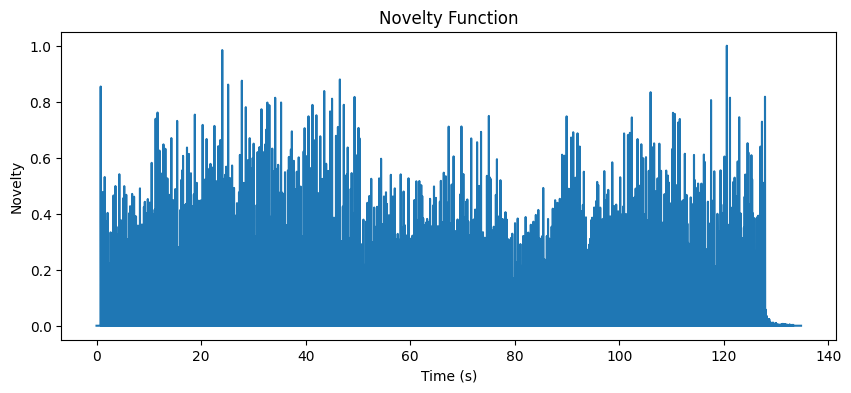

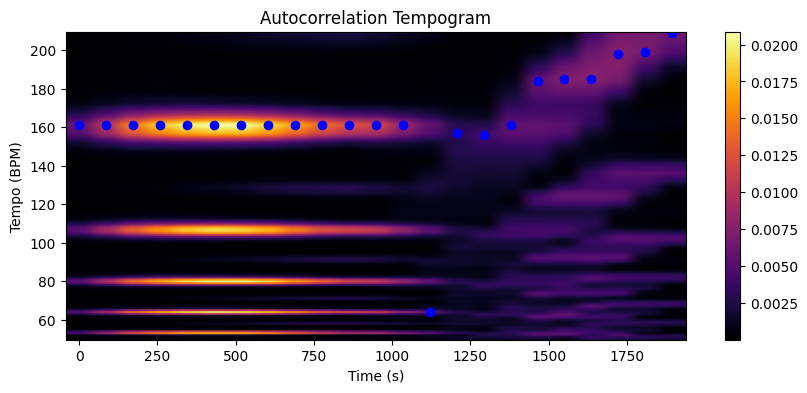

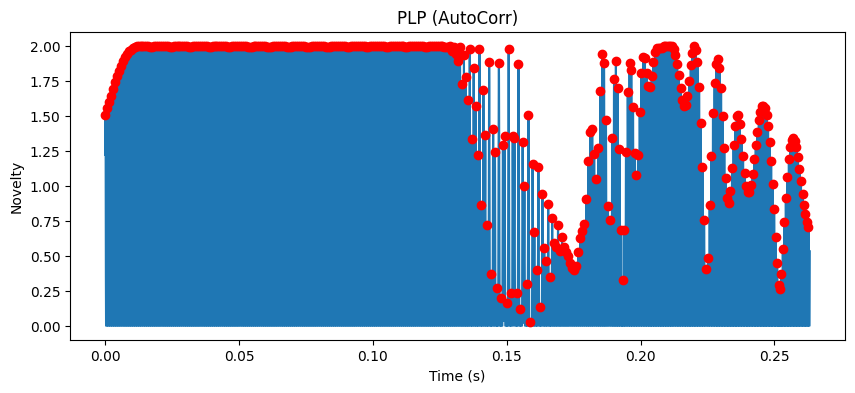

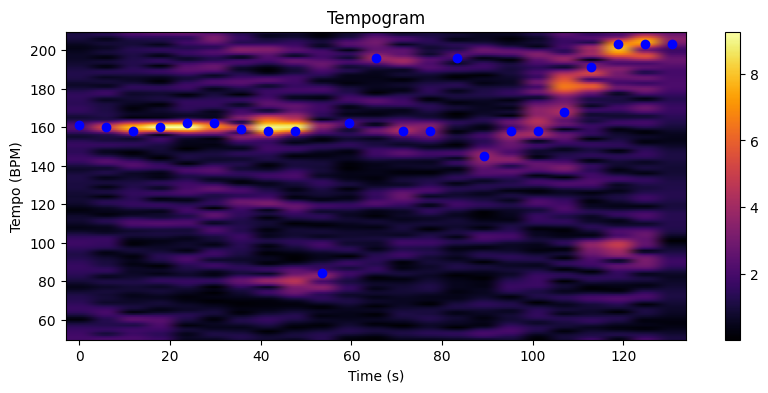

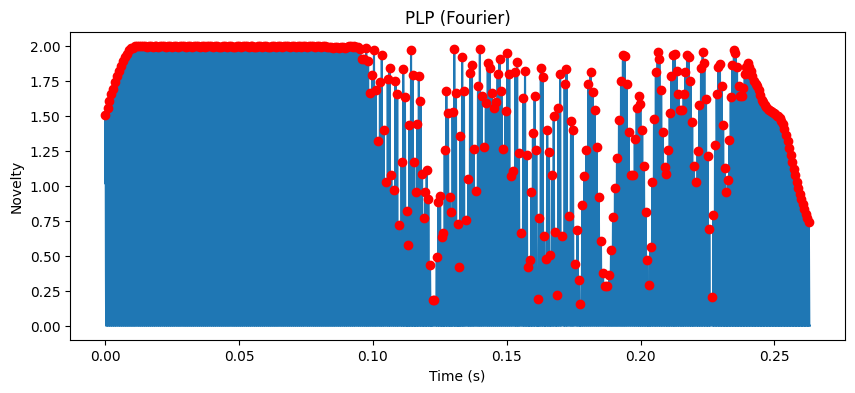

In [34]:
Theta = np.arange(50,210, 1)
beat_ACF, beat_ACF_s, beat_Fourier, beat_Fourier_s = final_results('res/Track 3.mp3', Theta = Theta)